# Clustering bank clients using K-Modes

El dataset de marketing bancario se presentó por primera vez en Moro, S., Laureano, R. y Cortex, P. (2011). Los datos están relacionados con campañas de marketing directo de una entidad bancaria portuguesa. Las campañas de marketing se basaban en llamadas telefónicas. 

En el artículo original, el conjunto de datos se utilizó para un problema de clasificación: predecir si un cliente ha suscrito o no un depósito a plazo basándose en características que incluían datos de clientes bancarios, datos sobre las campañas de marketing y algunos datos socioeconómicos. En este caso, sólo utilizamos los datos de los clientes bancarios para intentar agruparlos en distintos grupos. 

Este análisis puede ser importante para las instituciones bancarias a la hora de diseñar campañas de marketing, ya que el conocimiento de los diferentes grupos de clientes puede ayudar a los bancos a desarrollar diferentes campañas de marketing dirigidas a cada grupo de clientes, lo que puede ser potencialmente más eficaz que una campaña de marketing universal para todos los clientes.

**Descripción de las variables del dataset:**

*Datos del cliente bancario:*

1. edad (numérico)
2. empleo : tipo de empleo (categórico: "administrativo", "obrero", "empresario", "empleada doméstica", "directivo", "jubilado", "autónomo", "servicios", "estudiante", "técnico", "desempleado", "desconocido")
3. marital : estado civil (categórico: "divorciado", "casado", "soltero", "desconocido"; nota: "divorciado" significa divorciado o viudo)
4. educación (categórica: "primaria", "secundaria", "terciaria", "desconocida")
5. impago: ¿tiene un crédito impagado? (categórico: "no", "sí", "desconocido")
6. housing: has housing loan? (categorical: 'no','yes','unknown')
6. balance: saldo bancario
7. préstamo: ¿tiene préstamo personal? (categórico: "no", "sí", "desconocido")

*Relacionado con el último contacto de la campaña actual:*

9. contacto: tipo de comunicación del contacto (categórico: 'móvil','teléfono')
9. month: mes del año del último contacto (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: día de la semana del último contacto (categorical: 'mon','tue','wed','thu','fri')
11. duración: duración del último contacto, en segundos (numérico). Nota importante: este atributo afecta en gran medida al objetivo de salida (por ejemplo, si duration=0 entonces y='no'). Sin embargo, la duración no se conoce antes de realizar una llamada. Además, una vez finalizada la llamada, es obvio que y se conoce. Por lo tanto, esta entrada sólo debería incluirse a efectos comparativos y debería descartarse si la intención es tener un modelo predictivo realista.

*Otros atributos:*

13. campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)
13. pdays: número de días transcurridos desde que el cliente fue contactado por última vez en una campaña anterior (numérico; 999 significa que el cliente no fue contactado previamente)
14. previous: número de contactos realizados antes de esta campaña y para este cliente (numérico)
15. poutcome: resultado de la campaña de marketing anterior (categórico: "fracaso", "inexistente", "éxito")

*Atributos de contexto social y económico

17. emp.var.rate: tasa de variación del empleo - indicador trimestral (numérico)
17. cons.precio.idx: índice de precios al consumo - indicador mensual (numérico)
18. cons.conf.idx: índice de confianza del consumidor - indicador mensual (numérico)
19. euribor3m: tipo euribor a 3 meses - indicador diario (numérico)
20. nr.employed: número de empleados - indicador trimestral (numérico)

*Variable de salida (objetivo deseado):*

22. y: ¿ha suscrito el cliente un depósito a plazo? (binario: "sí", "no")

In [ ]:
!pip install kmodes

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from kmodes.kmodes import KModes
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Carga y preprocesado de datos

Cargamos los datos desde el archivo csv.

In [2]:
data = pd.read_csv('bank.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Solo nos quedamos con las 8 primeras columnas, correspondientes a datos bancarios de los clientes.

In [3]:
data = data.iloc[:, :8]
data.head()

,age,job,marital,education,default,balance,housing,loan
0,59,admin.,married,secondary,no,2343,yes,no
1,56,admin.,married,secondary,no,45,no,no
2,41,technician,married,secondary,no,1270,yes,no
3,55,services,married,secondary,no,2476,yes,no
4,54,admin.,married,tertiary,no,184,no,no


Comprobamos las dimensiones del dataset y eliminamos duplicados.

In [4]:
print(f'There are {data.shape[0]} rows and {data.shape[1]} columns.')

There are 11162 rows and 8 columns.


In [5]:
data.duplicated().sum()

846

In [6]:
data.drop_duplicates(inplace=True)

Eliminamos valores nulos:

In [7]:
data.isnull().sum()
data.dropna()

,age,job,marital,education,default,balance,housing,loan
0,59,admin.,married,secondary,no,2343,yes,no
1,56,admin.,married,secondary,no,45,no,no
2,41,technician,married,secondary,no,1270,yes,no
3,55,services,married,secondary,no,2476,yes,no
4,54,admin.,married,tertiary,no,184,no,no
...,...,...,...,...,...,...,...,...
11156,34,blue-collar,single,secondary,no,-72,yes,no
11157,33,blue-collar,single,primary,no,1,yes,no
11158,39,services,married,secondary,no,733,no,no
11159,32,technician,single,secondary,no,29,no,no


Comprobamos el tipo de dato de cada columna:

In [8]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
dtype: object

Todas aquellas columnas que aparecen como "object" son categóricas, que habremos de preprocesar.

In [9]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

for col in cat_cols:
    data[col] = data[col].astype('category')

data.dtypes

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
dtype: object

In [10]:
for col in cat_cols:
    print(f'{col}:')
    print(data[col].unique())
    print('\n')

job:
['admin.', 'technician', 'services', 'management', 'retired', ..., 'entrepreneur', 'housemaid', 'unknown', 'self-employed', 'student']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student', 'technician', 'unemployed', 'unknown']


marital:
['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']


education:
['secondary', 'tertiary', 'primary', 'unknown']
Categories (4, object): ['primary', 'secondary', 'tertiary', 'unknown']


default:
['no', 'yes']
Categories (2, object): ['no', 'yes']


housing:
['yes', 'no']
Categories (2, object): ['no', 'yes']


loan:
['no', 'yes']
Categories (2, object): ['no', 'yes']




### Variables categóricas

A continuación vamos a procesar las columnas categóricas para que puedan ser utilizadas en el algoritmo de clustering.

Esto implicará convertir las variables categóricas en variables numéricas.

Comenzamos visualizando la frecuencia de cada categoría en cada columna categórica, para hacernos una idea de cómo están distribuidas.

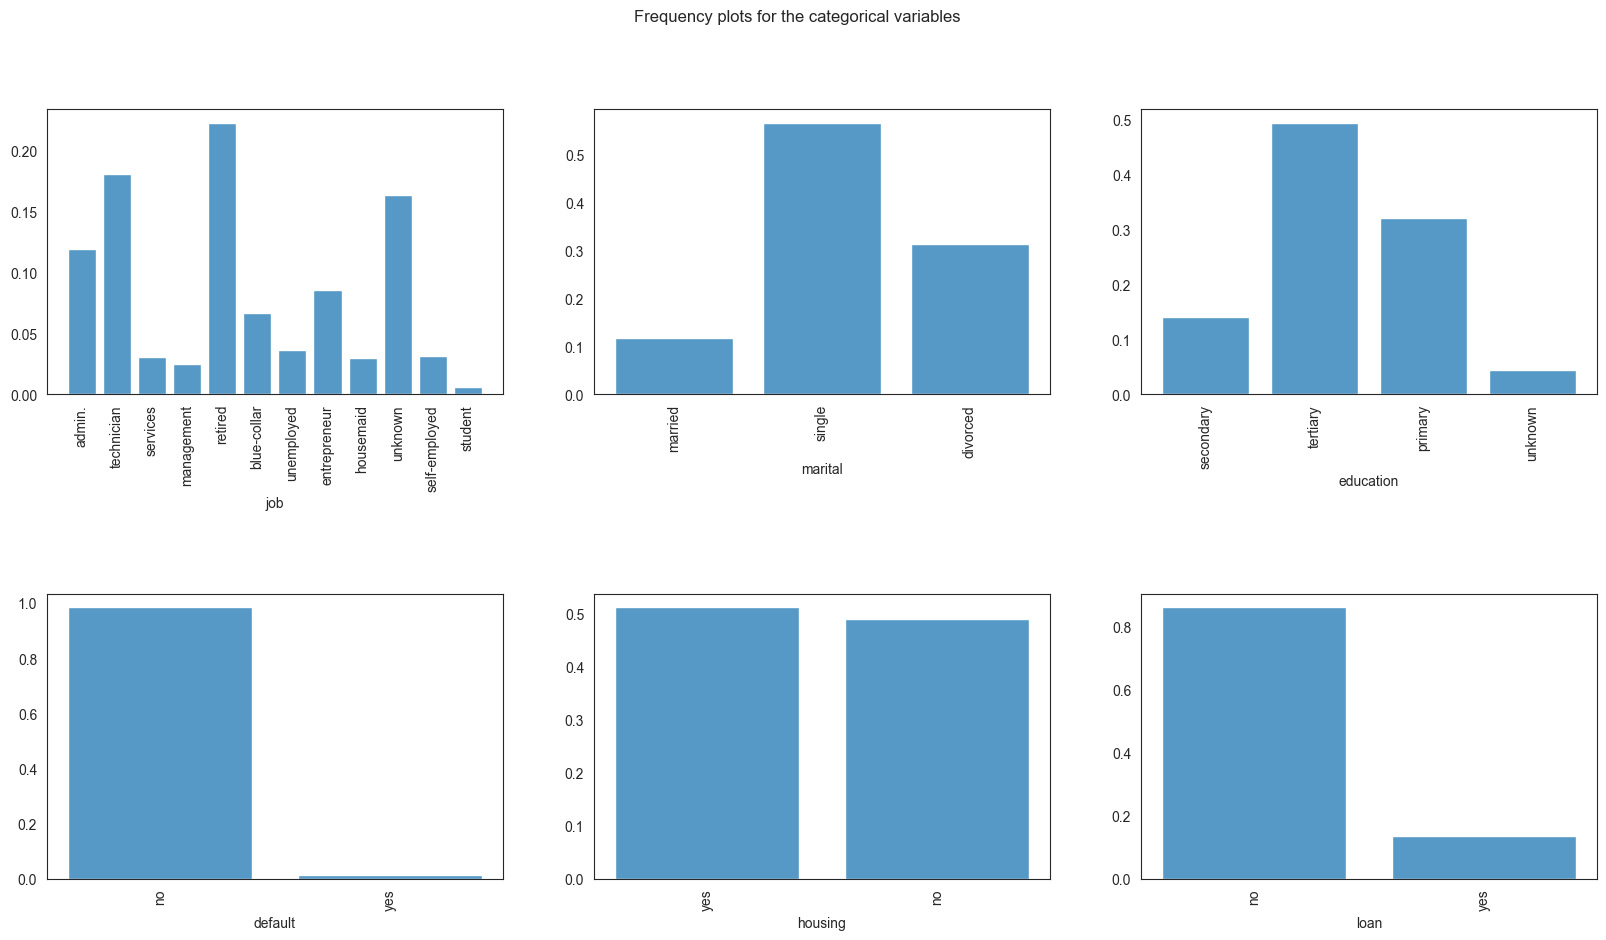

In [11]:
sns.set_style('white')

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.subplots_adjust(hspace=0.7)

sns.histplot(x = data['job'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axs[0,0])
axs[0,0].set_xticklabels(list(data['job'].unique()), rotation = 90)

sns.histplot(x = data['marital'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axs[0,1])
axs[0,1].set_xticklabels(list(data['marital'].unique()), rotation = 90)

sns.histplot(x = data['education'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axs[0,2])
axs[0,2].set_xticklabels(list(data['education'].unique()), rotation = 90)

sns.histplot(x = data['default'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axs[1,0])
axs[1,0].set_xticklabels(list(data['default'].unique()), rotation = 90)

sns.histplot(x = data['housing'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axs[1,1])
axs[1,1].set_xticklabels(list(data['housing'].unique()), rotation = 90)

sns.histplot(x = data['loan'], multiple="dodge", stat='density', shrink=0.8, common_norm=False, ax=axs[1,2])
axs[1,2].set_xticklabels(list(data['loan'].unique()), rotation = 90)

plt.suptitle('Frequency plots for the categorical variables')

for ax in axs.ravel():
    ax.set_ylabel('')

plt.show()

Se observa como muchos clientes están retirados, la mayoría están solteros o divorciados, la mayoría tiene estudios terciarios, no tiene impagos, créditos, etc.

Así mismo, si representamos una de las variables numéricas como es la edad, observamos una campana de Gauss centrada en 30-40 años, como corresponde a una idstribución normal de la población.

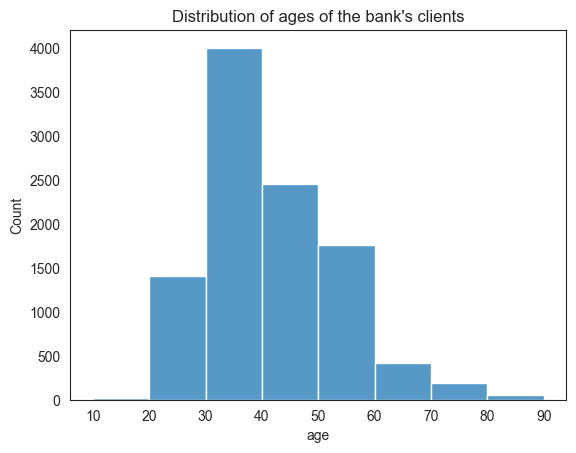

In [12]:
sns.histplot(data=data, x='age', bins=[10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.title("Distribution of ages of the bank's clients")
plt.xticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.ylabel('Count')
plt.show()

El balance, saldo en el banco, tiene un sesgo hacia menos de 10000 euros, con muy pocos clientes teniendo más.

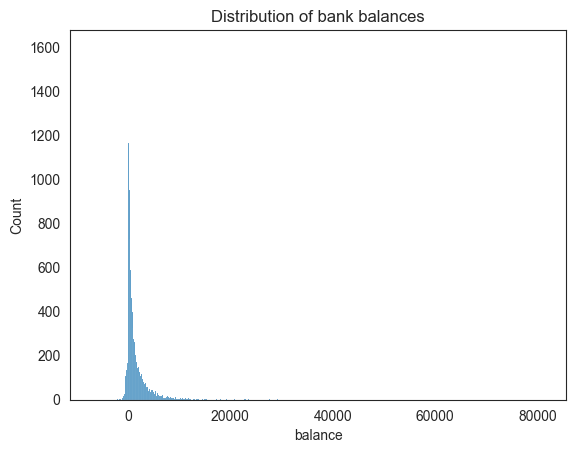

In [13]:
sns.histplot(data=data, x='balance')
plt.title("Distribution of bank balances")
plt.ylabel('Count')
plt.show()

#### **One Hot Encoding**

Para transformar las variables categóricas en numéricas, utilizaremos la técnica de "one-hot encoding", que consiste en crear una columna por cada categoría, y asignar un 1 a la columna correspondiente a la categoría del cliente, y 0 al resto.

In [14]:
data_ohe = data['marital']
data_ohe_dummies = pd.get_dummies(data_ohe)
data_ohe_concat = pd.concat([data_ohe, data_ohe_dummies], axis=1)
data_ohe_concat.head(20)

,marital,divorced,married,single
0,married,False,True,False
1,married,False,True,False
2,married,False,True,False
3,married,False,True,False
4,married,False,True,False
5,single,False,False,True
6,married,False,True,False
7,divorced,True,False,False
8,married,False,True,False
9,single,False,False,True


#### **Label Encoding**

Alternativamente, podemos utilizar la técnica de "label encoding", que consiste en asignar un número a cada categoría, de forma que cada categoría tenga un número distinto.

In [15]:
data_ohe = data['job']
# label encoding
data_ohe_labels = data_ohe.cat.codes
data_ohe_concat = pd.concat([data_ohe, data_ohe_labels], axis=1)
data_ohe_concat.head(20)

,job,0
0,admin.,0
1,admin.,0
2,technician,9
3,services,7
4,admin.,0
5,management,4
6,management,4
7,retired,5
8,technician,9
9,services,7


In [16]:
data_kmeans = pd.get_dummies(data, drop_first=True)
data_kmeans

,age,balance,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,59,2343,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
1,56,45,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
2,41,1270,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
3,55,2476,False,False,False,False,False,False,True,False,...,False,False,True,False,True,False,False,False,True,False
4,54,184,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156,34,-72,True,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,True,False
11157,33,1,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
11158,39,733,False,False,False,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,False
11159,32,29,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False


#### **Escalado**

Es una buena práctica escalar las variables antes de aplicar un algoritmo de clustering. Esto se debe a que los algoritmos de clustering se basan en la distancia entre puntos, y si una variable tiene una escala mucho mayor que el resto, dominará la distancia.

In [17]:
scaler = MinMaxScaler()
data_kmeans_scaled = scaler.fit_transform(data_kmeans)

In [18]:
data_kmeans_scaled

array([[0.53246753, 0.10437133, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49350649, 0.07827282, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2987013 , 0.09218521, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.27272727, 0.08608647, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18181818, 0.07809111, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32467532, 0.07776175, 0.        , ..., 0.        , 0.        ,
        1.        ]])

### KMeans

Comenzamos utilizando la agrupación K-Means. El algoritmo de agrupación K-Means funciona asignando inicialmente al azar K centros de agrupación en un espacio p dimensional, donde p es el número de características. A continuación, se calculan las distancias de cada observación a cada centro de clúster y se asigna la observación a su clúster más cercano. Normalmente, se toma la distancia euclídea como métrica. A continuación, se vuelven a calcular los centros de los clústers como la media de las observaciones de cada clúster. Este proceso se repite hasta que las asignaciones de los clústers no cambian en iteraciones sucesivas. La asignación final de los clústers depende de la asignación aleatoria inicial de las medias de los clústers. Por lo tanto, el algoritmo K-Means suele repetirse varias veces con diferentes asignaciones de clúster, y la mejor asignación de clúster, definida como aquella en la que la suma de distancias al cuadrado de los puntos de datos a su centro de clúster más cercano es la más baja (esta métrica también se conoce como inercia). 

En este caso, dejamos que el algoritmo K-Means se ejecute durante un máximo de 500 iteraciones, y repetimos con 10 inicializaciones aleatorias iniciales de centros de clústers. Probamos el algoritmo K-Means con 2 a 8 clústers. A continuación, trazamos las inercias de los algoritmos K-Means con diferentes números de clústers.

In [21]:
n_clusters = list(range(2, 20))

In [22]:
print(n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
n_clusters = [2, 3,4,5,6,7,8]

In [33]:
# Running the K-Means algorithm for different numbers of clusters:
n_clusters = list(range(2, 9))
inertias = []


print("Probamos KMeans con los siguientes números de clusters:", n_clusters)
for n in n_clusters:
    ### START CODE HERE ###
    print("KMeans con", n, "clusters")

    # Crear un objeto KMeans con el número de clusters deseado
    print("  Crear objeto KMeans con", n, "clusters")
    inigo_kmeans = KMeans(n_clusters = n)

    # Entrenar el modelo con los datos escalados
    print("  Entrenar modelo")
    inigo_kmeans.fit(data_kmeans_scaled)

    # Obtener la inercia del modelo
    print("  Extraer resultados.")
    inigo_inertia = inigo_kmeans.inertia_
    print("   - Inercia:", inigo_inertia)

    # Añadir la inercia a la lista de inercias
    print("  Añadir resultados a la lista")
    inertias.append(inigo_inertia)


    ### END CODE HERE ###




Probamos KMeans con los siguientes números de clusters: [2, 3, 4, 5, 6, 7, 8]
KMeans con 2 clusters
  Crear objeto KMeans con 2 clusters
  Entrenar modelo
  Extraer resultados.
   - Inercia: 17617.000494708685
  Añadir resultados a la lista
KMeans con 3 clusters
  Crear objeto KMeans con 3 clusters
  Entrenar modelo
  Extraer resultados.
   - Inercia: 15085.437570074815
  Añadir resultados a la lista
KMeans con 4 clusters
  Crear objeto KMeans con 4 clusters
  Entrenar modelo
  Extraer resultados.
   - Inercia: 13698.376764341732
  Añadir resultados a la lista
KMeans con 5 clusters
  Crear objeto KMeans con 5 clusters
  Entrenar modelo
  Extraer resultados.
   - Inercia: 12431.967331425833
  Añadir resultados a la lista
KMeans con 6 clusters
  Crear objeto KMeans con 6 clusters
  Entrenar modelo
  Extraer resultados.
   - Inercia: 11552.451865645544
  Añadir resultados a la lista
KMeans con 7 clusters
  Crear objeto KMeans con 7 clusters
  Entrenar modelo
  Extraer resultados.
   - Ine

In [30]:
inertias

[17617.00049470868,
 15084.873313128393,
 13688.621335612776,
 12431.474205300501,
 11681.07875869495,
 11102.894935670118,
 10462.405144589633,
 10069.036300400652,
 9748.353228414266,
 9262.379276320928,
 9045.648552987423,
 8570.060045311096,
 8201.69507502216,
 8273.516008890701,
 7977.170261146353,
 7648.510974888955,
 7491.172109428977,
 7286.776254503506]

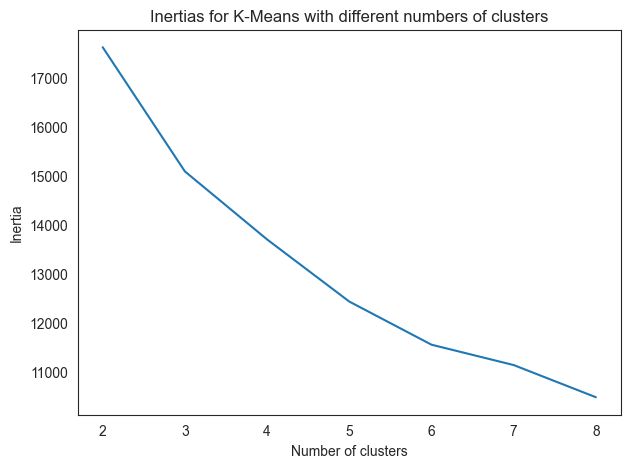

In [34]:
# Plotting the inertia:
plt.figure(figsize=(7, 5))
plt.plot(n_clusters, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertias for K-Means with different numbers of clusters')
plt.show()

Trás haber probado diferentes números de clúster, elijo el que más me convenga en función del problema a resolver, en este caso 3 clústers.

Creo un nuevo objeto (final) con 3 clústers (o los que yo haya considerado).

In [35]:
kmeans_inigo_final = KMeans(n_clusters = 3)
kmeans_inigo_final.fit(data_kmeans_scaled)

# save kmeans to file
import joblib
joblib.dump(kmeans_inigo_final, "kmeans_inigo_final.pkl")

['kmeans_inigo_final.pkl']

In [ ]:
from sklearn.cluster import KMeans
import joblib

# load kmeans from file
kmeans_inigo_carga = joblib.load("kmeans_inigo_final.pkl")
kmeans_inigo_carga.predict(nuevos_datos)

Podemos elegir el número óptimo de clústers utilizando el llamado método del codo, en el que buscamos un "codo" en el gráfico de inercia, es decir, un punto a partir del cual la caída de la inercia se vuelve bruscamente más gradual. Por tanto, según el método del codo, se elegirían 3 clústers.

In [66]:
data_kmeans = data_kmeans_scaled.copy()

In [67]:
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, random_state=42)
data['cluster_k-means'] = kmeans.fit_predict(data_kmeans)

## K-Modes

Dado que nuestros datos son mayoritariamente categóricos, es probable que el algoritmo K-Means, que calcula la distancia euclídea entre los centros de los clústers y cada punto de datos, no produzca un buen agrupamiento, ya que la distancia euclídea entre los centros de los clústers y las características categóricas, que han sido codificadas con un solo punto y, por tanto, toman valores 0 ó 1, no tiene mucho sentido. El algoritmo K-Modes es una modificación de K-Means más adecuada para datos categóricos. En lugar de calcular la distancia euclidiana entre los puntos de datos y los centros de los clústers, en K-Modes se utiliza una medida de disimilitud, que se define como el número de características del punto de datos cuyos valores no coinciden con los del centro del clúster. Además, los centros de los clústers se actualizan utilizando la moda de los puntos de datos asignados a cada clúster, en lugar de la media. 

A continuación, convertimos la edad y el balance en cuenta en variables categóricas mediante la clasificación por intervalos, y codificamos todas las variables categóricas en un solo paso. A continuación, aplicamos el algoritmo K-Modes para 2 a 8 clústers. A continuación, elaboramos gráficos del coste para cada número de clústers. El coste del algoritmo K-Modes se define como la suma de las disimilitudes de cada punto de datos.

In [68]:
# Binning the age columns and one-hot encoding:

data_kmodes = data.drop('cluster_k-means', axis=1).copy()
data_kmodes['age_binned'] = pd.cut(data_kmodes['age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype('category')
data_kmodes.drop('age', axis=1, inplace=True)
data_kmodes['balance_binned'] = pd.cut(data_kmodes['balance'], bins=[2000, 5000, 10000, 20000, 50000, 100000]).astype('category')
data_kmodes.drop('balance', axis=1, inplace=True)
data_kmodes = pd.get_dummies(data_kmodes, drop_first=True)

Running K-Modes for 2 clusters...
Running K-Modes for 3 clusters...
Running K-Modes for 4 clusters...
Running K-Modes for 5 clusters...
Running K-Modes for 6 clusters...
Running K-Modes for 7 clusters...
Running K-Modes for 8 clusters...


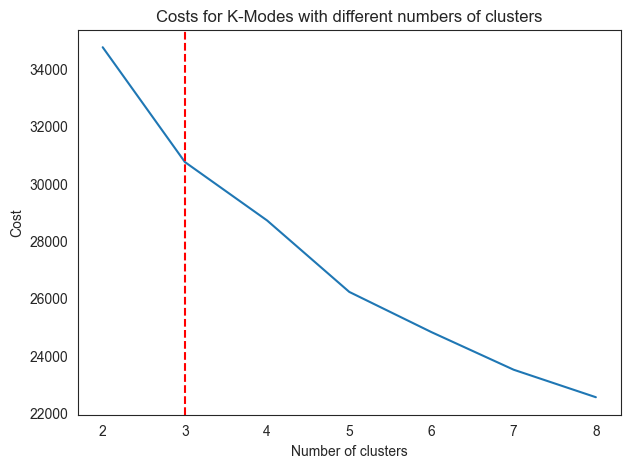

In [69]:
# Running the K-Modes algorithm for different numbers of clusters:

n_clusters = list(range(2, 9))
costs = []

for n in n_clusters:
    print(f'Running K-Modes for {n} clusters...')
    kmodes = KModes(n_clusters=n)
    kmodes.fit(data_kmodes)
    cost = kmodes.cost_
    costs.append(cost)

# Plotting the cost:

plt.figure(figsize=(7,5))
plt.plot(n_clusters, costs)
plt.axvline(3, linestyle='--', c='r')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Costs for K-Modes with different numbers of clusters')
plt.show()

In [70]:
kmodes = KModes(n_clusters=3, init='random', n_init=10, max_iter=500, random_state=42)
data['cluster_k-modes'] = kmodes.fit_predict(data_kmodes)

### Hierarchical clustering

El clustering jerárquico es un enfoque ascendente del clustering que no requiere que especifiquemos el número de clusters. 

En primer lugar, trata cada punto de datos como un clúster propio. A continuación, se combinan los clústers más similares. Este proceso continúa hasta que todas las observaciones se agrupan en un solo clúster. 

Para determinar los dos clusters más similares, hay que definir una medida de disimilitud junto con un método de vinculación. La medida de disimilitud suele definirse como la distancia euclídea. 
Una alternativa es la disimilitud basada en la correlación, que es uno menos el coeficiente de correlación. Dónde el coeficiente de correlación es una medida de la similitud entre dos variables.

La medida de desemejanza puede utilizarse para medir la "desemejanza" entre dos puntos de datos. Para extender esta noción de disimilitud a los clústers, hay que definir un método de vinculación. En general, se utilizan tres métodos de vinculación: completo, medio y único. En todos estos métodos de vinculación, primero se calculan las medidas de disimilitud entre todos los puntos de datos de dos clústers. A continuación:

- En la vinculación completa, se utiliza el valor máximo de estas disimilitudes entre puntos de datos para determinar la disimilitud entre los dos clústers. 
- En la vinculación media, el valor medio de las disimilitudes entre los puntos de datos se utiliza para determinar la disimilitud entre los dos clústers.
- En la vinculación simple, se utiliza el valor mínimo de las disimilitudes entre los puntos de datos.

El clustering jerárquico puede utilizarse para producir un dendrograma, que es un diagrama en forma de árbol que tiene todos los puntos de datos como clusters individuales en la parte inferior. A medida que ascendemos en el dendrograma, se van formando clusters, uno a uno, hasta que terminamos con un único cluster que contiene todos los puntos de datos en la parte superior.

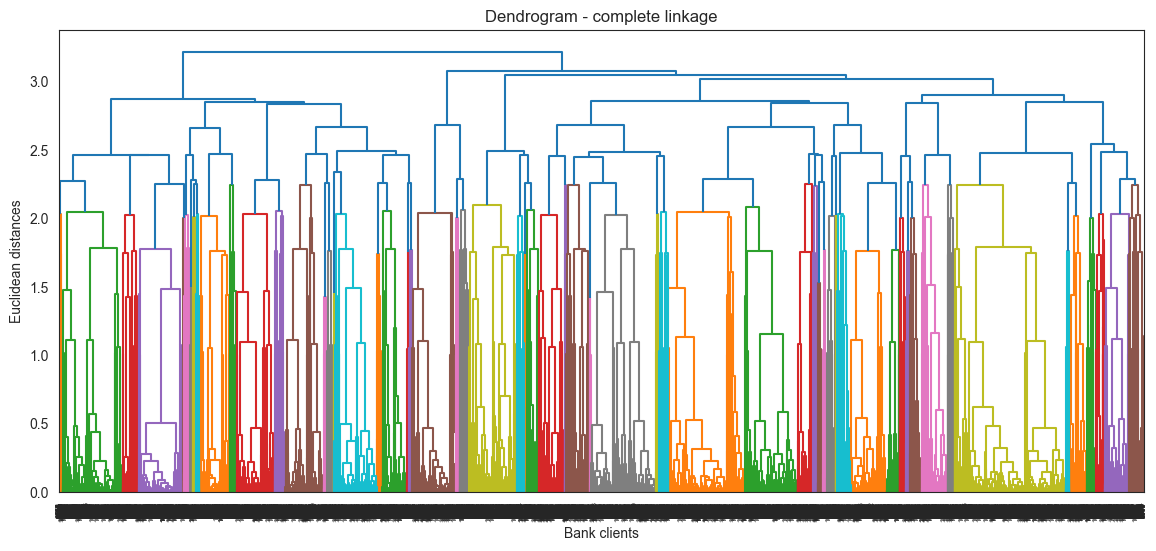

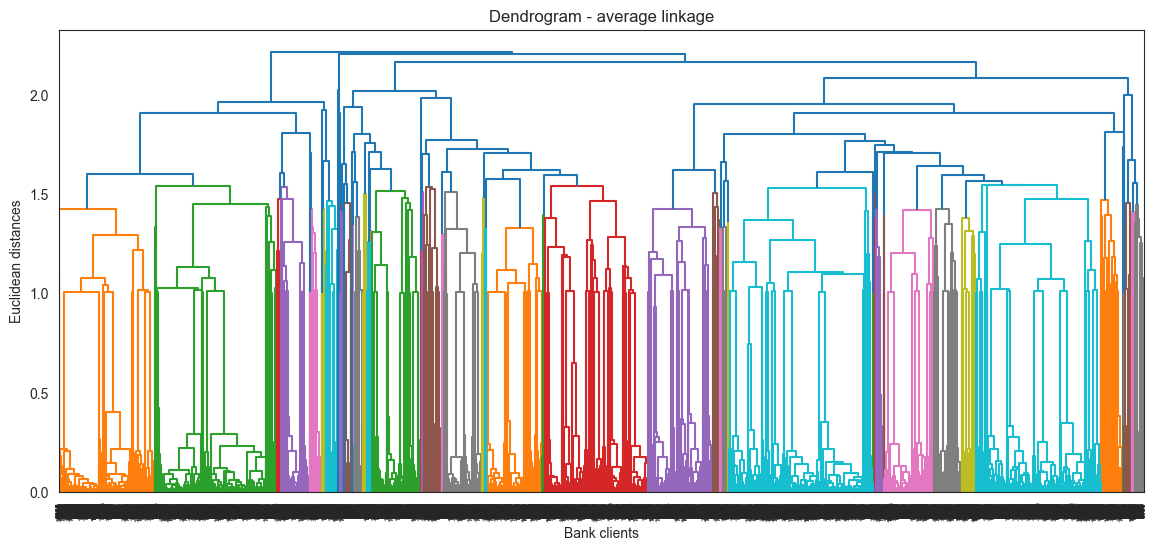

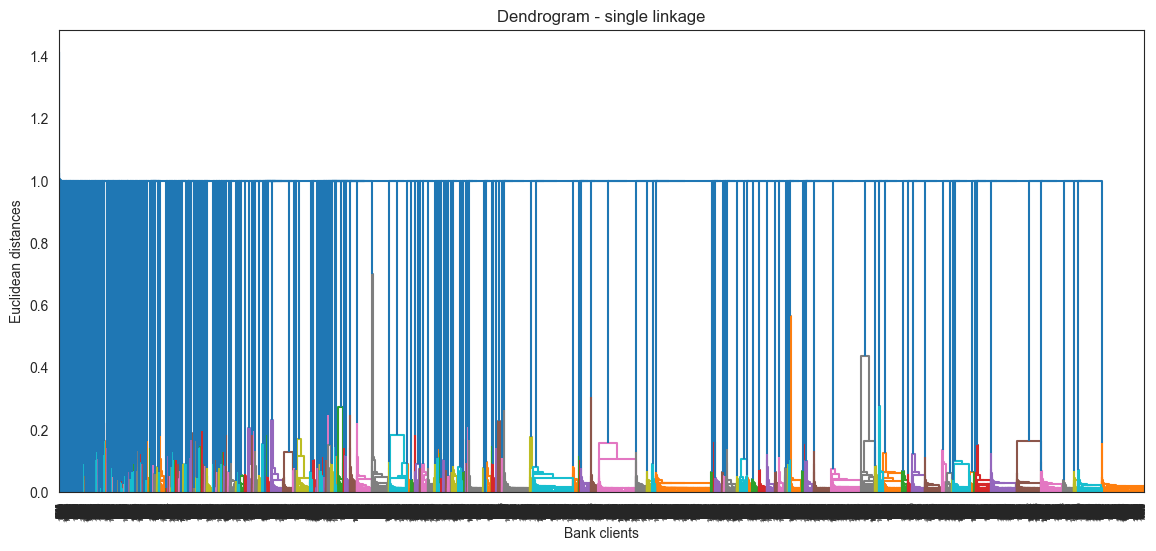

In [71]:
data_hc = data_kmeans.copy()

plt.figure(figsize=(14, 6))
hc_complete = linkage(data_hc, method='complete')
dendrogram_complete = dendrogram(hc_complete)
plt.title('Dendrogram - complete linkage')
plt.xlabel('Bank clients')
plt.ylabel('Euclidean distances')
plt.show()

plt.figure(figsize=(14, 6))
hc_average = linkage(data_hc, method='average')
dendrogram_average = dendrogram(hc_average)
plt.title('Dendrogram - average linkage')
plt.xlabel('Bank clients')
plt.ylabel('Euclidean distances')
plt.show()

plt.figure(figsize=(14, 6))
hc_single = linkage(data_hc, method='single')
dendrogram_single = dendrogram(hc_single)
plt.title('Dendrogram - single linkage')
plt.xlabel('Bank clients')
plt.ylabel('Euclidean distances')
plt.show()

In [72]:
data['cluster_hc'] = cut_tree(hc_complete, 3)[:, 0]

## Reducción de dimensionalidad con PCA para permitir la visualización

Usamos Principal Component Analysis (PCA) para obtener una representación en 2 dimensions.

PCA es una técnica de reducción de dimensionalidad que se utiliza para reducir el número de variables en un conjunto de datos. PCA transforma las variables originales en un nuevo conjunto de variables, que son ortogonales entre sí y que son combinaciones lineales de las variables originales. Las nuevas variables se denominan componentes principales. 

- La primera componente principal es la combinación lineal de las variables originales que explica la mayor parte de la varianza en los datos. 
- La segunda componente principal es la combinación lineal de las variables originales que explica la mayor parte de la varianza en los datos, y que es ortogonal a la primera componente principal.
- Y así sucesivamente.

Emplearemos PCA para obtener las dos priemerias componentes principales, y representar los datos en un gráfico de dispersión.

In [73]:
# Scaling the original features:

features = data.iloc[:, :8]
features = pd.get_dummies(features, drop_first=True)
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Getting the first two principal components:

pca = PCA(2)
data_pca = pd.DataFrame(pca.fit_transform(features), columns=['Principal component 1', 'Principal component 2'])

# Printing the explained variance ratio:

explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
print(f'Proportion of variance of the original features explained by the first two principal components: {explained_variance_ratio}')

# Appending the cluster labels to the PCA dataframe:

data_pca = pd.concat([data_pca, data.iloc[:, 8:11]], axis=1)

Proportion of variance of the original features explained by the first two principal components: 0.22755009018307545


Las dos primeras componentes explican el 22.75 % de la varianza, un valor muy bajo, pero suficiente para visualizar los datos.

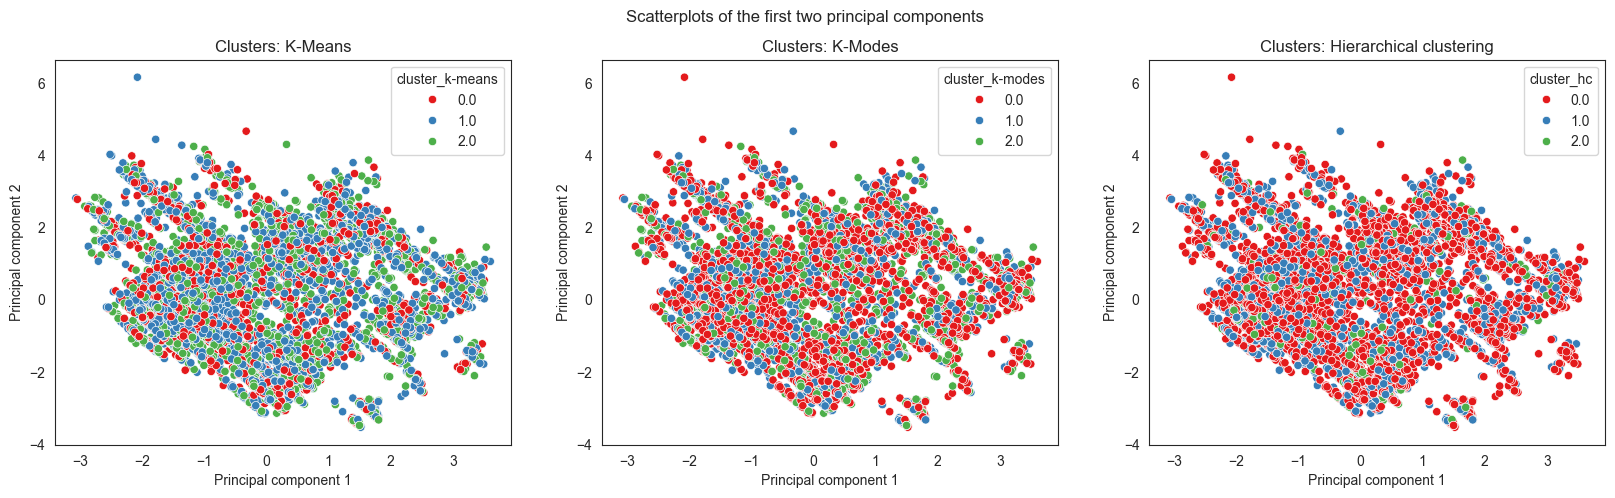

In [74]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.scatterplot(data=data_pca, x='Principal component 1', y='Principal component 2', hue='cluster_k-means', ax=axs[0], palette='Set1')
axs[0].set_title('Clusters: K-Means')
sns.scatterplot(data=data_pca, x='Principal component 1', y='Principal component 2', hue='cluster_k-modes', ax=axs[1], palette='Set1')
axs[1].set_title('Clusters: K-Modes')
sns.scatterplot(data=data_pca, x='Principal component 1', y='Principal component 2', hue='cluster_hc', ax=axs[2], palette='Set1')
axs[2].set_title('Clusters: Hierarchical clustering')
fig.suptitle('Scatterplots of the first two principal components')
plt.show()

Ninguno de los algoritmos considerados produjo agrupaciones bien asentadas en los dos primeros componentes principales. Hay que señalar, sin embargo, que el análisis basado en los dos primeros componentes principales en este caso puede no ser apropiado por dos razones. En primer lugar, como ya se ha explicado, los dos primeros componentes principales sólo explican una pequeña proporción de la varianza total de las características originales. En segundo lugar, el ACP suele aplicarse a datos numéricos, mientras que en nuestro caso la mayoría de las características son categóricas. Pueden utilizarse métodos alternativos de reducción de la dimensionalidad, como el FAMD (análisis factorial de datos mixtos), para obtener una representación dimensional más precisa de los datos.

Dado que el análisis basado en los dos primeros componentes principales no arroja resultados concluyentes sobre el rendimiento relativo de los algoritmos de agrupación elegidos, elegimos el algoritmo de agrupación que mejor se adapta a los datos (mayoritariamente) categóricos, es decir, el algoritmo K-Modes, y lo utilizamos para el análisis posterior de nuestros datos.

In [75]:
data.drop(['cluster_k-means', 'cluster_hc'], axis=1, inplace=True)

## Análisis de los datos por clúster

Frecuencia para la variable 'job' por clúster.

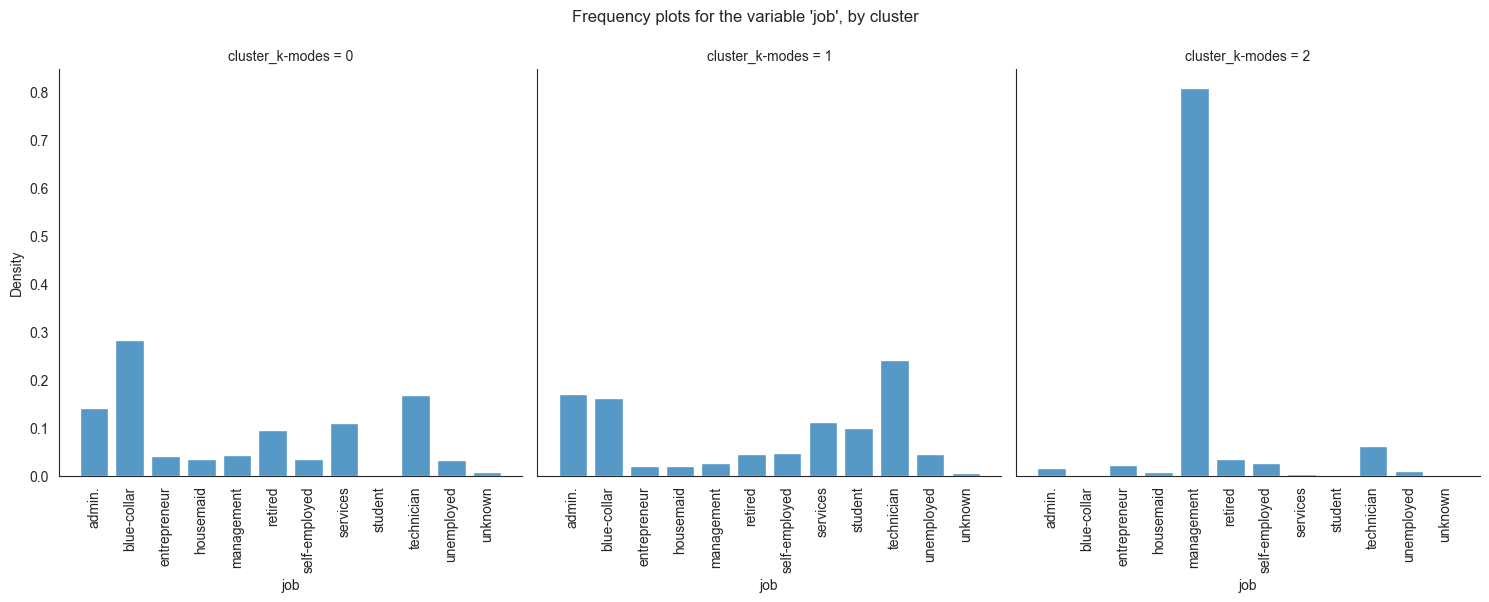

In [76]:
g = sns.displot(data=data, x='job', col='cluster_k-modes', multiple="dodge", stat='density', shrink=0.8, common_norm=False)
g.set_xticklabels(rotation=90)
g.fig.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)
plt.show()

Frecuencia de la variable 'marital' por clúster.

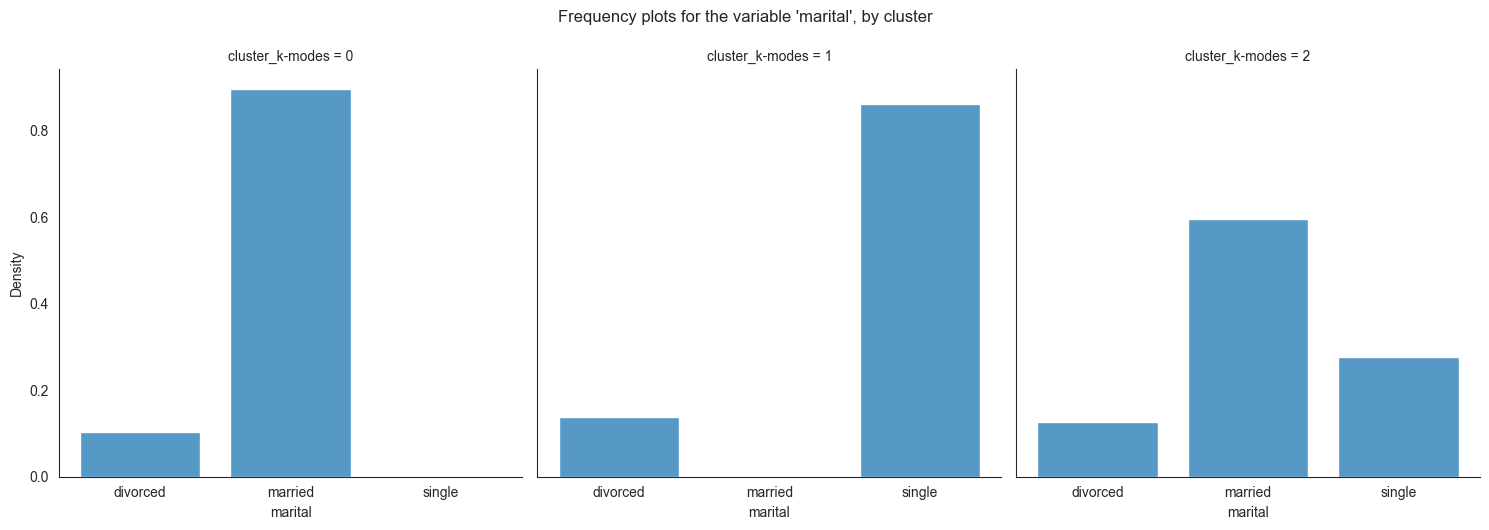

In [77]:
g = sns.displot(data=data, x='marital', col='cluster_k-modes', multiple="dodge", stat='density', shrink=0.8, common_norm=False)
g.fig.suptitle("Frequency plots for the variable 'marital', by cluster", y=1.05)
plt.show()

Frecuencia de la variable 'education' por clúster.

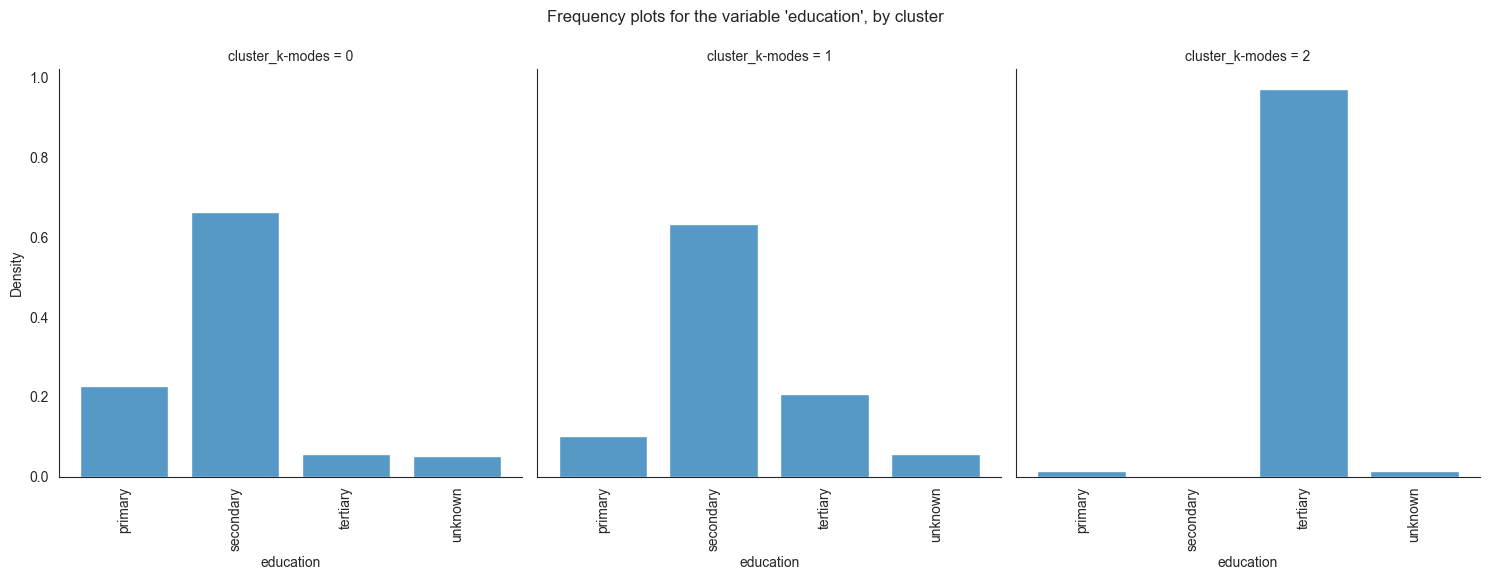

In [78]:
g = sns.displot(data=data, x='education', col='cluster_k-modes', multiple="dodge", stat='density', shrink=0.8, common_norm=False)
g.set_xticklabels(rotation=90)
g.fig.suptitle("Frequency plots for the variable 'education', by cluster", y=1.05)
plt.show()

Frecuencia de la variable 'default' por clúster.

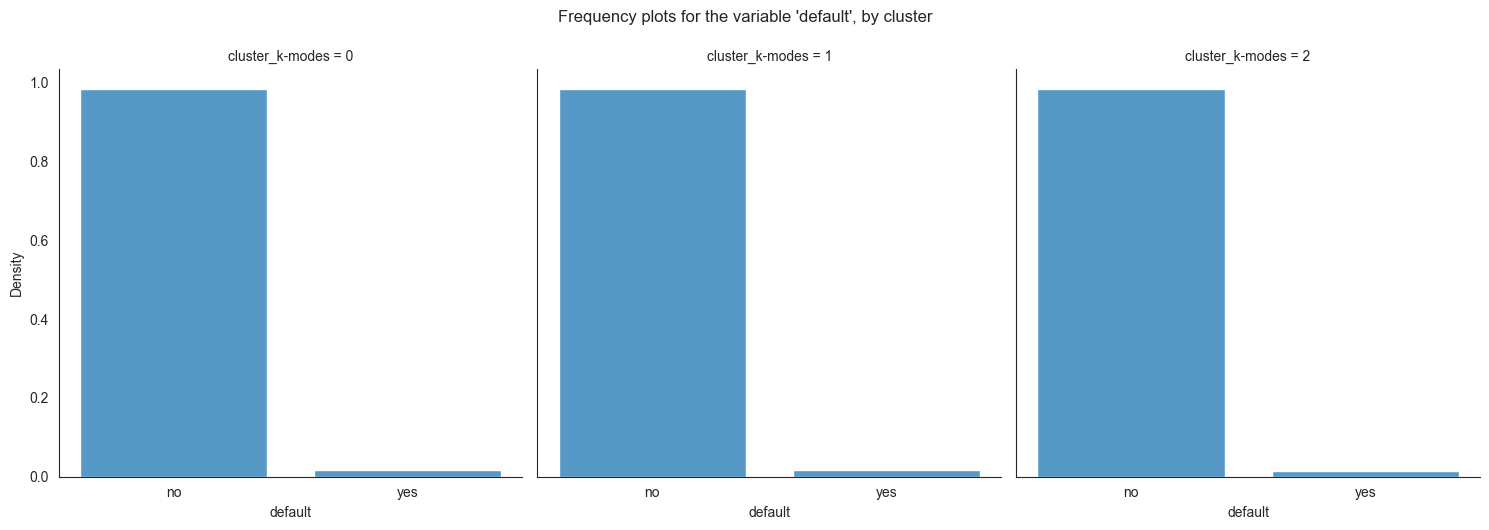

In [79]:
g = sns.displot(data=data, x='default', col='cluster_k-modes', multiple="dodge", stat='density', shrink=0.8, common_norm=False)
g.fig.suptitle("Frequency plots for the variable 'default', by cluster", y=1.05)
plt.show()

Frecuencia de la variable 'housing' por clúster.

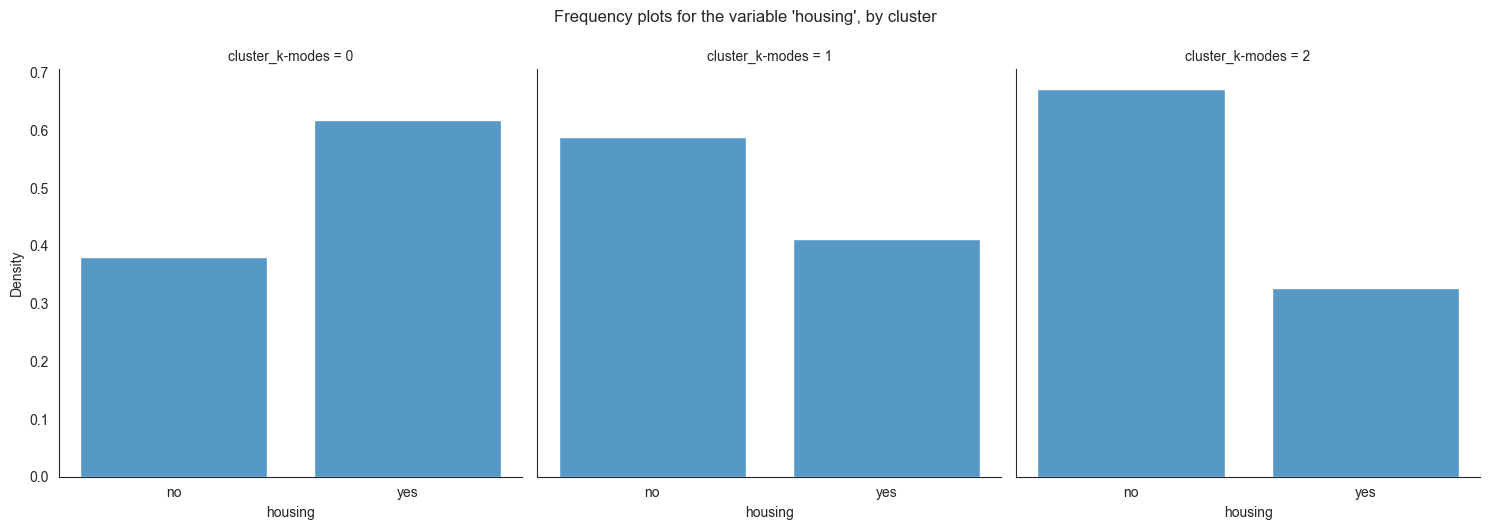

In [81]:
g = sns.displot(data=data, x='housing', col='cluster_k-modes', multiple="dodge", stat='density', shrink=0.8, common_norm=False)
g.fig.suptitle("Frequency plots for the variable 'housing', by cluster", y=1.05)
plt.show()

Frecuencia de la variable 'loan' por clúster.

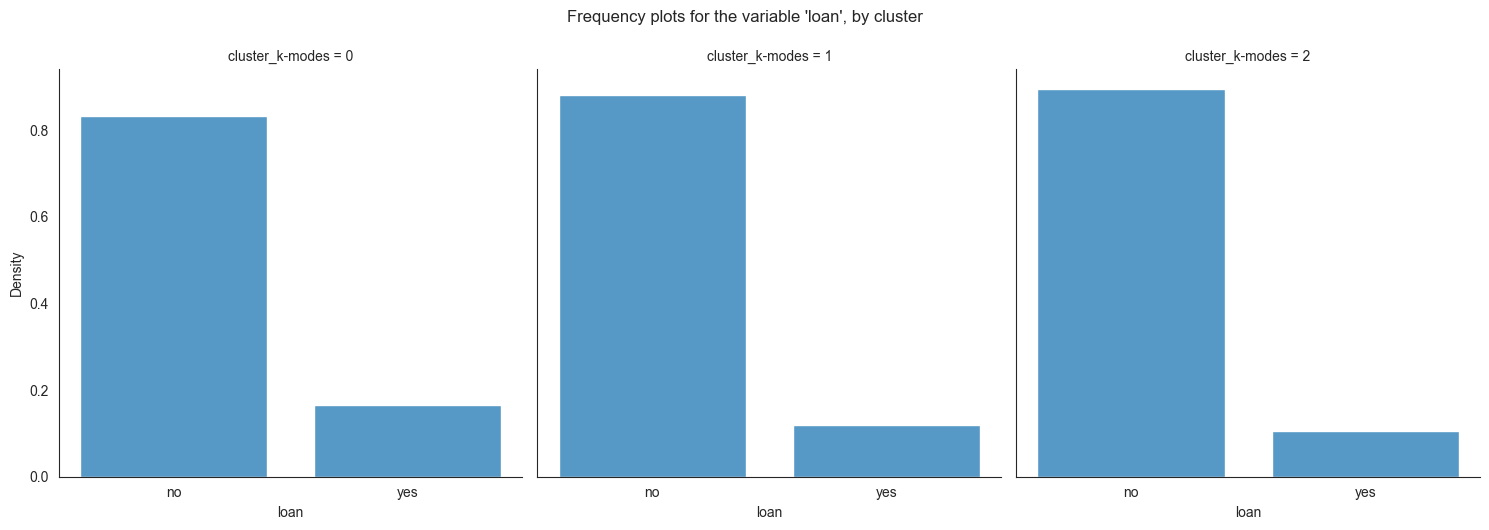

In [82]:
g = sns.displot(data=data, x='loan', col='cluster_k-modes', multiple="dodge", stat='density', shrink=0.8, common_norm=False)
g.fig.suptitle("Frequency plots for the variable 'loan', by cluster", y=1.05)
plt.show()

Frecuencia de la variable 'contact' por clúster.

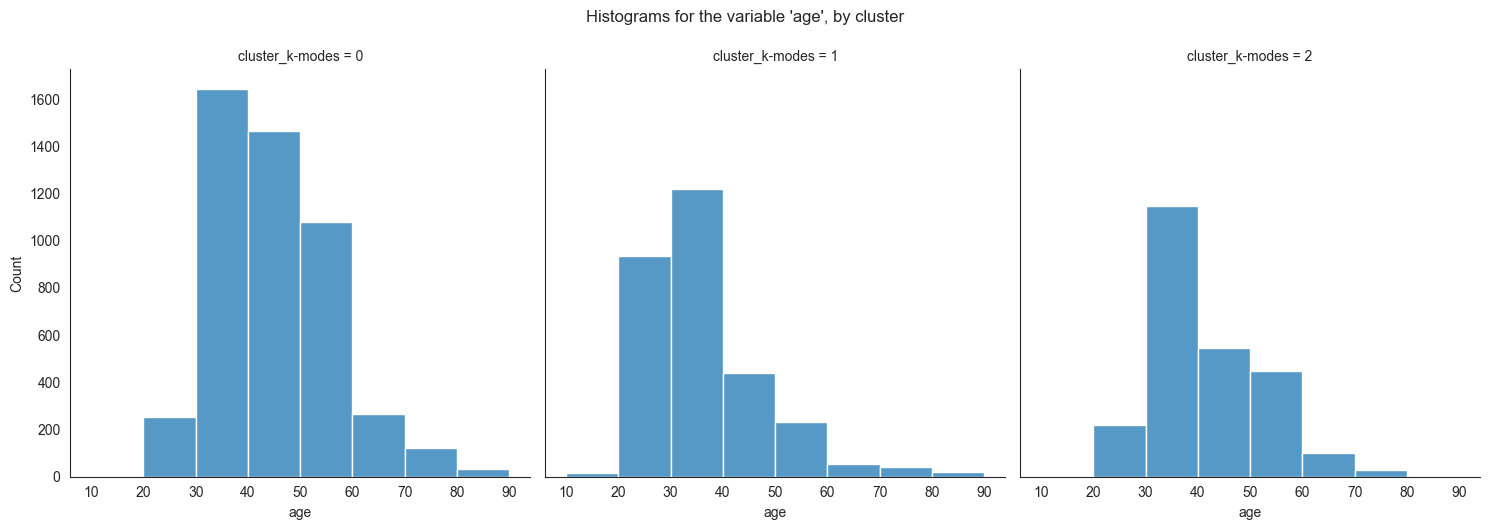

In [83]:
g = sns.displot(data=data, x='age', col='cluster_k-modes', bins=[10, 20, 30, 40, 50, 60, 70, 80, 90])
g.fig.suptitle("Histograms for the variable 'age', by cluster", y=1.05)
plt.show()

Frecuencia de la variable 'balance' por clúster.

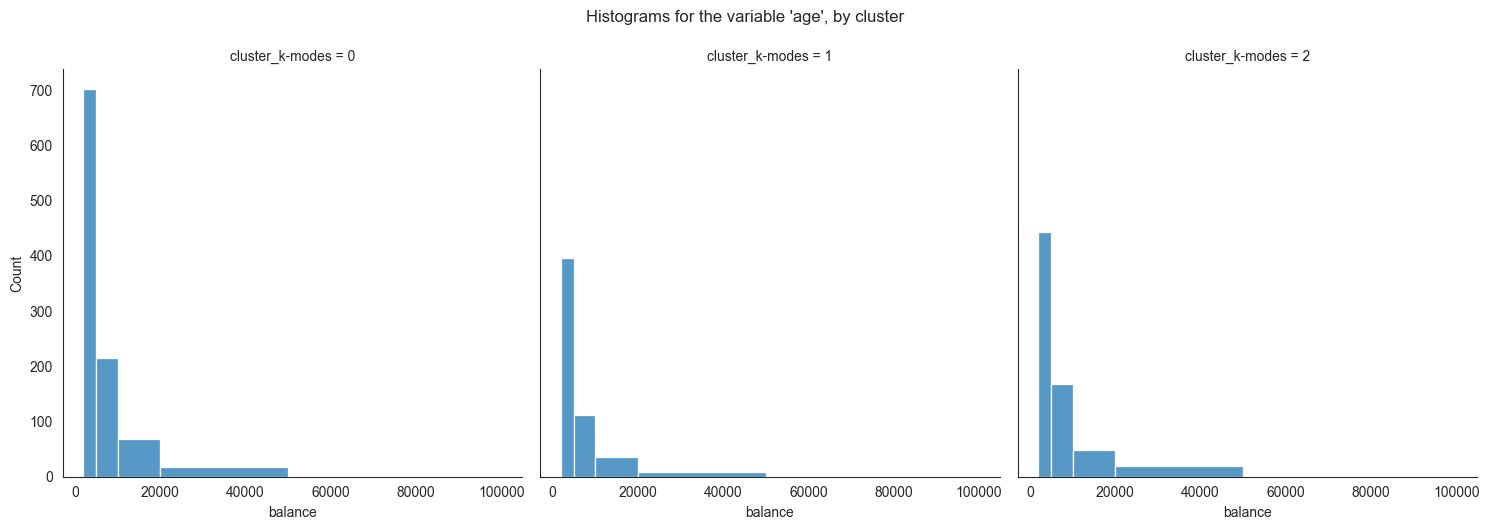

In [84]:
g = sns.displot(data=data, x='balance', col='cluster_k-modes', bins=[2000, 5000, 10000, 20000, 50000, 100000])
g.fig.suptitle("Histograms for the variable 'age', by cluster", y=1.05)
plt.show()

## Conclusión

Resumen de las diferencias entre las agrupaciones:

- Grupo 0: ...
- Grupo 1: ...
- Grupo 2: ...
